#### Create the masks

In [1]:
import os
from PIL import Image
import numpy as np

# Define the directory paths
input_masks_dir = r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_masks'  # Replace with your directory
output_masks_dir = r'C:\Users\DELL\Desktop\SSY340_Project\comma10k_custom'  # Replace with your output directory

# Create output directory if it doesn't exist
os.makedirs(output_masks_dir, exist_ok=True)

# Define the road color in RGB
road_color = (64, 32, 32)  # Convert hex #402020 to RGB

def create_binary_mask(mask_path):
    mask = Image.open(mask_path).convert("RGB")  # Load mask as RGB
    mask_array = np.array(mask)  # Convert to numpy array
    
    # Create a binary mask
    binary_mask = np.all(mask_array[:, :, :3] == road_color, axis=-1).astype(np.uint8)  # 1 where road, 0 elsewhere
    return binary_mask

# Iterate through all mask images, convert to binary, and save
for filename in os.listdir(input_masks_dir):
    if filename.endswith('.png'):  # Assuming your masks are in PNG format
        mask_path = os.path.join(input_masks_dir, filename)
        binary_mask = create_binary_mask(mask_path)
        
        # Save the binary mask
        output_mask_path = os.path.join(output_masks_dir, filename.replace('.png', '_binary.png'))
        Image.fromarray(binary_mask * 255).save(output_mask_path)  # Save as binary image

print("Binary masks created and saved.")


Binary masks created and saved.


#### Dataset Class


In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch

class Comma10kDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get a list of all images and masks
        self.img_files = []
        self.mask_files = []
        
        for img_file in os.listdir(img_dir):
            if img_file.endswith('.png'):  # Assuming your images are in PNG format
                self.img_files.append(os.path.join(img_dir, img_file))
                mask_file = img_file.replace('.png', '_binary.png')  # Assuming binary masks have a similar naming
                self.mask_files.append(os.path.join(mask_dir, mask_file))

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        mask_path = self.mask_files[idx]
        
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Load mask as grayscale
        
        if self.transform:
            img = self.transform(img)
            mask = self.transform(mask)
        
        return img, mask

# Define transformations for the images and masks
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for the model
    transforms.ToTensor(),
])

# Create dataset instance
dataset = Comma10kDataset(img_dir='comma10k_imgs', mask_dir='comma10k_custom', transform=transform)


In [2]:
sample_img, sample_mask = dataset[0]  # Get the first item
print(sample_img.size())
print(sample_mask.size())

torch.Size([3, 224, 224])
torch.Size([1, 224, 224])


#### Dataloaders

##### I limit to 5000 images to follow the split of cityscapes

In [24]:
from sklearn.model_selection import train_test_split

# Ensure you have a dataset with 5000 images
if len(dataset) > 5000:
    dataset = torch.utils.data.Subset(dataset, range(5000))  # Limit to the first 5000 images

# Define total number of images and split ratios
total_images = 5000
test_size = 1525
remaining_images = total_images - test_size
train_size = int(remaining_images * 0.8)  # 80% for training
val_size = remaining_images - train_size  # Remaining for validation

# Get the indices for train and test splits
train_indices, test_indices = train_test_split(range(len(dataset)), test_size=test_size, random_state=42)

# From the training indices, further split for validation
train_indices, val_indices = train_test_split(train_indices, test_size=val_size / (train_size + val_size), random_state=42)

# Create data subsets
train_subset = torch.utils.data.Subset(dataset, train_indices)
val_subset = torch.utils.data.Subset(dataset, val_indices)
test_subset = torch.utils.data.Subset(dataset, test_indices)

# Create DataLoaders
batch_size = 4  # Adjust as needed
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
comma10k_test_loader = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

# Output dataset sizes for verification
print(f"Training dataset size: {len(train_loader.dataset)}")
print(f"Validation dataset size: {len(val_loader.dataset)}")
print(f"Testing dataset size: {len(comma10k_test_loader.dataset)}")


Training dataset size: 1160
Validation dataset size: 290
Testing dataset size: 1525


#### UNet Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoding path with downsampling
        self.encoder1 = self.conv_block(in_channels, 32, dropout_rate=0.3)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = self.conv_block(32, 64, dropout_rate=0.3)
        self.pool2 = nn.MaxPool2d(2)
        self.encoder3 = self.conv_block(64, 128, dropout_rate=0.3)
        self.pool3 = nn.MaxPool2d(2)
        self.encoder4 = self.conv_block(128, 256, dropout_rate=0.3)
        self.pool4 = nn.MaxPool2d(2)

        # Middle layers
        self.middle = self.conv_block(256, 512, dropout_rate=0.3)

        # Decoding path with upsampling
        self.upconv4 = self.upconv_block(512, 256)
        self.decoder4 = self.conv_block(512, 256, dropout_rate=0.3)
        self.upconv3 = self.upconv_block(256, 128)
        self.decoder3 = self.conv_block(256, 128, dropout_rate=0.3)
        self.upconv2 = self.upconv_block(128, 64)
        self.decoder2 = self.conv_block(128, 64, dropout_rate=0.3)
        self.upconv1 = self.upconv_block(64, 32)
        self.decoder1 = self.conv_block(64, 32, dropout_rate=0.3)

        # Final output
        self.final_conv = nn.Conv2d(32, out_channels, kernel_size=1)

    def conv_block(self, in_channels, out_channels, dropout_rate=0.3):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        # Encoding path
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        mid = self.middle(self.pool4(enc4))

        # Decoding path with skip connections
        dec4 = torch.cat((self.upconv4(mid), enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = torch.cat((self.upconv3(dec4), enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = torch.cat((self.upconv2(dec3), enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = torch.cat((self.upconv1(dec2), enc1), dim=1)
        dec1 = self.decoder1(dec1)

        output = self.final_conv(dec1)
        return output

# Create the UNet model
model = UNet(in_channels=3, out_channels=1)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


UNet(
  (encoder1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): Dropout(p=0.3, inplace=False)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (encoder2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.3, inplace=False)
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

#### Train Model

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import numpy as np
import seaborn as sns

# Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    f1_scores = []
    jaccard_indices = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        total_correct_train = 0
        total_pixels_train = 0
        
        model.train()  # Set to training mode
        print(f"Start epoch {epoch+1}/{num_epochs}")

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()  # Zero the gradients
            outputs = model(images)  # Forward pass
            
            loss = criterion(outputs, masks)  # Calculate loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update weights
            
            epoch_loss += loss.item()  # Accumulate loss
            preds = torch.sigmoid(outputs) > 0.5  # Get predictions
            total_correct_train += (preds == masks.byte()).sum().item()  # Correct predictions
            total_pixels_train += masks.numel()  # Total pixels in the mask

        # Store training metrics
        train_losses.append(epoch_loss / len(train_loader))
        train_accuracy = total_correct_train / total_pixels_train
        train_accuracies.append(train_accuracy)

        print(f"Epoch [{epoch + 1}/{num_epochs}], Training Loss: {train_losses[-1]:.4f}, Training Accuracy: {train_accuracy:.4f}")

        # Validation phase
        model.eval()  # Set to evaluation mode
        eval_loss = 0
        total_correct_eval = 0
        total_pixels_eval = 0
        all_preds = []
        all_masks = []

        with torch.no_grad():
            for eval_images, eval_masks in val_loader:
                eval_images, eval_masks = eval_images.to(device), eval_masks.to(device)

                eval_outputs = model(eval_images)  # Forward pass
                eval_loss += criterion(eval_outputs, eval_masks).item()  # Calculate loss

                preds = torch.sigmoid(eval_outputs) > 0.5  # Get predictions
                total_correct_eval += (preds == eval_masks.byte()).sum().item()
                total_pixels_eval += eval_masks.numel()

                # Store predictions and masks for metrics
                all_preds.append(preds.cpu().numpy().flatten())
                all_masks.append(eval_masks.cpu().numpy().flatten())

        # Calculate metrics
        val_losses.append(eval_loss / len(val_loader))
        val_accuracy = total_correct_eval / total_pixels_eval
        val_accuracies.append(val_accuracy)

        # Binarize predictions and ground truths for metric calculation
        all_preds = (np.concatenate(all_preds) > 0.5).astype(int)  # Convert to binary
        all_masks = (np.concatenate(all_masks) > 0.5).astype(int)  # Convert to binary

        # Calculate F1-Score and Jaccard Index
        f1 = f1_score(all_masks, all_preds, average='binary')
        jaccard = jaccard_score(all_masks, all_preds, average='binary')
        f1_scores.append(f1)
        jaccard_indices.append(jaccard)

        print(f"Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracy:.4f}, F1-Score: {f1:.4f}, Jaccard Index: {jaccard:.4f}")

    # Plot the metrics at the end of all epochs
    plot_metrics(
        epochs=range(1, num_epochs + 1),
        train_losses=train_losses,
        val_losses=val_losses,
        train_accuracies=train_accuracies,
        val_accuracies=val_accuracies,
        f1_scores=f1_scores,
        jaccard_indices=jaccard_indices
    )

# Function to plot the metrics
def plot_metrics(epochs, train_losses, val_losses, train_accuracies, val_accuracies, f1_scores, jaccard_indices):
    plt.figure(figsize=(20, 6))

    # Plotting Losses
    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plotting Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot F1-Score and Jaccard Index
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1_scores, label='F1-Score')
    plt.plot(epochs, jaccard_indices, label='Jaccard Index (IoU)')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('F1-Score and Jaccard Index')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Run the training process
print("Running...")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)


Running...
Start epoch 1/5


KeyboardInterrupt: 

In [7]:
def save_checkpoint(model, optimizer, epoch, file_path):
    """Saves the model and optimizer state to a checkpoint file."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, file_path)
    print(f"Checkpoint saved to {file_path}")

def load_checkpoint(model, optimizer, file_path):
    """Loads the model and optimizer state from a checkpoint file."""
    checkpoint = torch.load(file_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint loaded from {file_path}, starting from epoch {epoch}")
    return epoch

In [33]:
# Assume training has completed, and you want to save everything
final_epoch = 8  # The final epoch after training
checkpoint_path = 'unet_8_comma10kdata_checkpoint.pth'  # Define the checkpoint file path

# Save the final checkpoint (model, optimizer, and epoch)
save_checkpoint(model, optimizer, final_epoch, checkpoint_path)
print("Checkpoint saved.")

Checkpoint saved to unet_8_comma10kdata_checkpoint.pth
Checkpoint saved.


In [10]:
import torch.optim as optim
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, jaccard_score, confusion_matrix
import numpy as np
import seaborn as sns

def test_model(model, test_loader, criterion):
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    total_correct_test = 0
    total_pixels_test = 0
    all_preds = []
    all_masks = []

    with torch.no_grad():
        for test_image, test_mask in test_loader:
            test_image, test_mask = test_image.to(device), test_mask.to(device)

            test_output = model(test_image)
            loss = criterion(test_output, test_mask)

            preds = (torch.sigmoid(test_output) > 0.5).float()  # Convert predictions to binary
            total_correct_test += (preds == test_mask.byte()).sum().item()
            total_pixels_test += test_mask.numel()

            # Store predictions and masks for metrics
            all_preds.append(preds.cpu().numpy().flatten())
            all_masks.append(test_mask.cpu().numpy().flatten())

            running_loss += loss.item()

    avg_loss = running_loss / len(test_loader)
    accuracy = total_correct_test / total_pixels_test

    # Calculate F1-Score and Jaccard Index (IoU) using sklearn
    all_preds = np.concatenate(all_preds)
    all_masks = np.concatenate(all_masks)

    # Ensure all_preds and all_masks are binary
    all_preds = (all_preds > 0.5).astype(np.uint8)  # Ensure predictions are binary
    all_masks = (all_masks > 0.5).astype(np.uint8)  # Ensure masks are binary

    f1 = f1_score(all_masks, all_preds, average='binary')
    jaccard = jaccard_score(all_masks, all_preds, average='binary')

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_masks, all_preds)

    print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}, Jaccard Index (IoU): {jaccard:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

    # Optionally visualize the confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix on Test Data')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return avg_loss, accuracy, f1, jaccard, conf_matrix


Testing the model...
Test Loss: 0.1990, Test Accuracy: 0.9155
F1-Score: 0.8666, Jaccard Index (IoU): 0.7646
Confusion Matrix:
[[49050361  2466547]
 [ 4000279 21001213]]


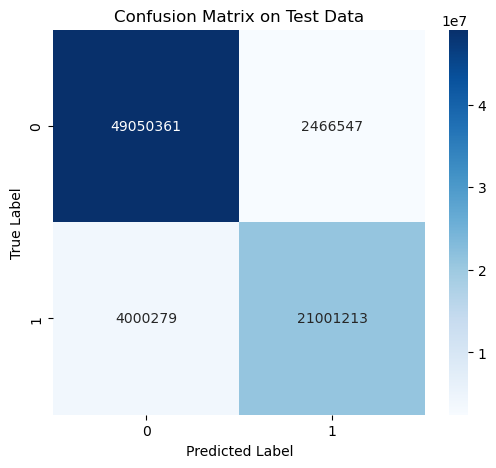

In [30]:
# Assuming you have already defined model, criterion, optimizer, and loaded the test_loader
print("Testing the model...")
test_loss, test_accuracy, test_f1, test_jaccard, test_confusion_matrix = test_model(model, comma10k_test_loader, criterion)


#### Test on KITTI

In [13]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import torch

class KITTIDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        
        # Get a list of all images and masks
        self.img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.png')])
        self.mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('.png')])
        
        # Ensure both lists are of the same length
        if len(self.img_files) != len(self.mask_files):
            raise ValueError(f"Number of images {len(self.img_files)} does not match number of masks {len(self.mask_files)}")
        
        # Create pairs based on their order in the directories
        self.pairs = [(os.path.join(img_dir, img), os.path.join(mask_dir, mask)) 
                      for img, mask in zip(self.img_files, self.mask_files)]

    def __len__(self):
        return len(self.pairs)

    def preprocess_mask(self, mask):
        """
        Convert a colored mask to a binary mask:
        - 1 for road (RGB: [255, 0, 255])
        - 0 for non-road (RGB: [255, 0, 0])
        """
        # Convert the mask to a NumPy array
        mask_array = np.array(mask)

        # Create a binary mask: 1 for road, 0 for non-road
        binary_mask = np.zeros(mask_array.shape[:2], dtype=np.uint8)  # Initialize binary mask
        binary_mask[(mask_array[:, :, 0] == 255) & (mask_array[:, :, 1] == 0) & (mask_array[:, :, 2] == 255)] = 1  # Road
        binary_mask[(mask_array[:, :, 0] == 255) & (mask_array[:, :, 1] == 0) & (mask_array[:, :, 2] == 0)] = 0  # Non-road

        # Convert to a torch tensor and add a channel dimension (1xHxW)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0).float()

        return binary_mask

    def __getitem__(self, idx):
        img_path, mask_path = self.pairs[idx]
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # Apply transformations to the image
        if self.transform:
            img = self.transform(img)
        
        # Resize the mask to match the image size
        mask = mask.resize((224, 224), Image.NEAREST)  # Ensure mask is resized correctly

        # Preprocess the mask (convert to binary)
        mask = self.preprocess_mask(mask)
        
        return img, mask


# Define your transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),
])

# Create the dataset
kitti_data_dir = r'C:\Users\DELL\Desktop\SSY340_Project\kitti_data_road\data_road\training\image_2'  # Path to the image_2 folder
kitti_gt_dir = r'C:\Users\DELL\Desktop\SSY340_Project\kitti_data_road\data_road\training\gt_image_2'  # Path to the ground truth folder
kitti_dataset = KITTIDataset(img_dir=kitti_data_dir, mask_dir=kitti_gt_dir, transform=transform)

# Create DataLoader
kitti_loader = DataLoader(kitti_dataset, batch_size=4, shuffle=False)  # Adjust batch size as needed

# Output number of samples in the dataset for verification
print(f"Number of samples in the dataset: {len(kitti_dataset)}")


Number of samples in the dataset: 289


Testing the model on KITTI dataset...
Test Loss: 0.3547, Test Accuracy: 0.8749
F1-Score: 0.6146, Jaccard Index (IoU): 0.4436
Confusion Matrix:
[[11240946   693692]
 [ 1119970  1446256]]


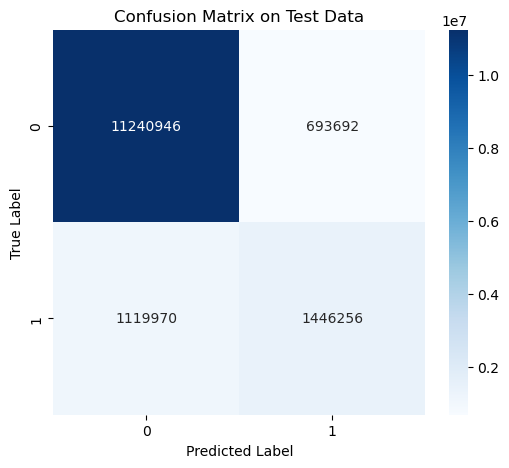

In [31]:
print("Testing the model on KITTI dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, kitti_loader, criterion)

#### Test on CityScape

In [16]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms
import torch
import numpy as np

road_color = [128, 64, 128]  # RGB value for road

class CityscapesDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        
        self.img_files = []
        self.mask_files = []
        
        for city in os.listdir(self.img_dir):
            city_path = os.path.join(self.img_dir, city)
            for img_file in os.listdir(city_path):
                if img_file.endswith('_leftImg8bit.png'):
                    self.img_files.append(os.path.join(city_path, img_file))
                    mask_file = img_file.replace('_leftImg8bit.png', '_road_custom_mask.png')
                    self.mask_files.append(os.path.join(self.mask_dir, city, mask_file))
    
    def __len__(self):
        return len(self.img_files)

    def preprocess_mask(self, mask):
        mask_array = np.array(mask)

        if mask_array.shape[-1] == 4:
            mask_array = mask_array[:, :, :3]

        binary_mask = np.all(mask_array == road_color, axis=-1).astype(np.uint8)
        binary_mask = torch.from_numpy(binary_mask).unsqueeze(0).float()

        if self.mask_transform:
            binary_mask = self.mask_transform(binary_mask)

        return binary_mask

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        img = Image.open(img_path).convert("RGB")
        mask_path = self.mask_files[idx]
        mask = Image.open(mask_path)

        if self.transform:
            img = self.transform(img)
        
        mask = self.preprocess_mask(mask)
        
        return img, mask

# Define transformations
vgg16_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

mask_transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=Image.NEAREST)
])

# Paths for the dataset
img_dir = r'C:\Users\DELL\Desktop\SSY340_Project\leftImg8bit\train'
mask_dir = r'C:\Users\DELL\Desktop\SSY340_Project\gt_custom\train'

# Load the Cityscapes dataset and sample 300 images
batch_size = 4
dataset = CityscapesDataset(img_dir=img_dir, mask_dir=mask_dir, transform=vgg16_transform, mask_transform=mask_transform)
sample_size = 300
sample_subset = Subset(dataset, range(min(sample_size, len(dataset))))
sample_loader = DataLoader(sample_subset, batch_size=batch_size, shuffle=False, num_workers=0)

# Output subset size for verification
print(f"Sample subset size: {len(sample_loader.dataset)}")

# Example: Iterate through a batch of data to verify
for images, masks in sample_loader:
    print(f"Image batch shape: {images.shape}")
    print(f"Mask batch shape: {masks.shape}")  # Should be [4, 1, 224, 224]
    break  # Stop after first batch for verification


Sample subset size: 300
Image batch shape: torch.Size([4, 3, 224, 224])
Mask batch shape: torch.Size([4, 1, 224, 224])


Testing the model on cityscape dataset...
Test Loss: 0.1781, Test Accuracy: 0.9246
F1-Score: 0.8836, Jaccard Index (IoU): 0.7914
Confusion Matrix:
[[9607416  496966]
 [ 638693 4309725]]


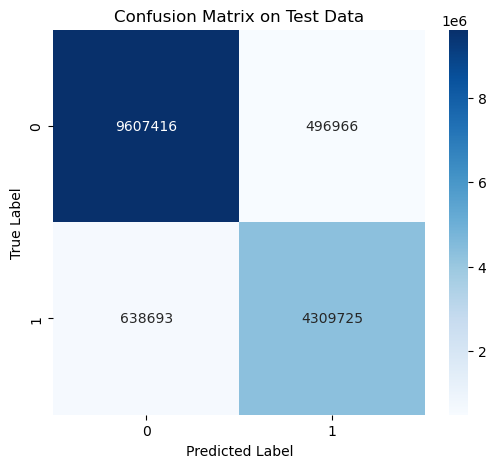

In [32]:
print("Testing the model on cityscape dataset...")
test_loss, test_accuracy, test_f1, test_jaccard, test_conf_matrix = test_model(model, sample_loader , criterion)